In [ ]:
!pip install dydx-v3-python


In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
from dydx3 import Client
import matplotlib.pyplot as plt


In [17]:
client = Client(
        host='https://api.dydx.exchange',
        )
markets = {'dYdX': ['BTC-USD', 'ETH-USD']}
timeframe = '1HOUR'

In [22]:
def get_ohlcv(market, timeframe):
        '''1DAY, 4HOURS, 1HOUR, 30MINS, 15MINS, 5MINS, 1MIN'''
        while True:
            try:
                candles = client.public.get_candles(
                market=market,
                resolution=timeframe,
                )
                break
            except Exception as e:
                print('data_ema_signal get_ohlcv error', datetime.now(), e)

        return candles.data

In [19]:
def create_df(data):
        ohlcv = data['candles']
        df = pd.DataFrame(data = ohlcv, columns = ['startedAt',
                                                   'open',
                                                   'high',
                                                   'low',
                                                   'close',
                                                   'usdVolume'])
        df = df.rename(columns={'startedAt': 'timestamp', 'usdVolume': 'volume'})
        #inversion
        df = df[::-1]
        df = df.reset_index()
        #convert data types
        df['open'] = df['open'].astype(float)
        df['high'] = df['high'].astype(float)
        df['low'] = df['low'].astype(float)
        df['close'] = df['close'].astype(float)
        df['volume'] = df['volume'].astype(float)
        #print(df)
        return df

In [23]:
ohlcv = get_ohlcv(market='BTC-USD', timeframe='1HOUR')

In [24]:
df = create_df(ohlcv)

In [25]:
def calc_best_fit_line(df):
        '''transforms price to straight line '''
        x = df.close
        y = range(len(x))
        best_fit_line = np.poly1d(np.polyfit(y, x, 1))(y)
        df['ma'] = best_fit_line
        return df

In [26]:
def plot_ma(df):
        plt.figure(figsize=(10, 6))

        plt.plot(df.index, df['close'], label='Price', color='black')

        plt.plot(df.index, df['ma'], label='ma', color='blue')
        plt.grid(True)
        plt.show()

In [28]:
df = calc_best_fit_line(df)

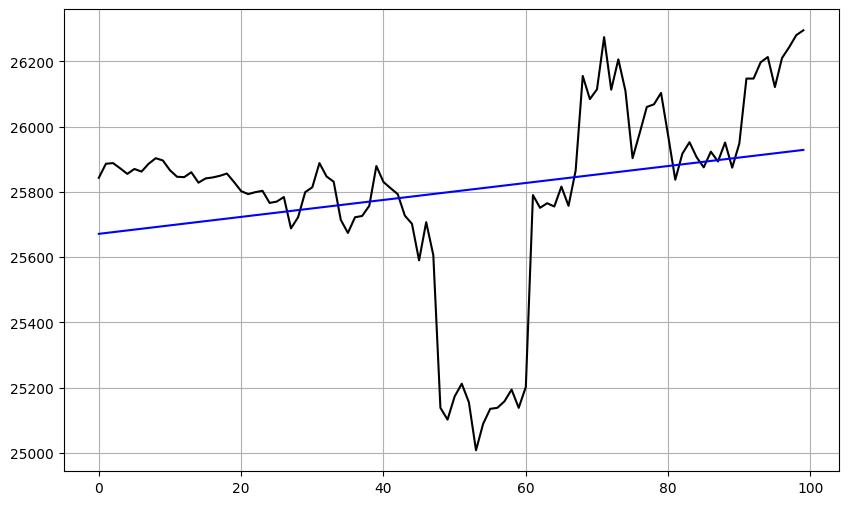

In [29]:
plot_ma(df)

In [30]:
def calc_std_dev_n( df):
        df['price_diff'] = df['close'].diff()
        df['std_dev'] = df['price_diff'].rolling(window=5).std()

        #alternative to MA
        df = calc_best_fit_line(df)
        df['n_std'] = (df['ma'] - df['close']) / df['std_dev']

        #df['n_std'] = df['n_std'].rolling(5).mean()

        print(df[['close', 'std_dev', 'n_std']])


        top_border = df['n_std'].quantile(0.9)
        bottom_border = df['n_std'].quantile(0.1)

        print(f'top border is {top_border}, bottom border is {bottom_border}')

        df['n_std_signal'] = 0  # Initialize 'signal' column with zeros
        df.loc[(df['n_std'] > top_border) & (df['n_std'] < df['n_std'].shift()) & (df['close'] < df['ma']), 'n_std_signal'] = 1
        df.loc[(df['n_std'] < bottom_border) & (df['n_std'] > df['n_std'].shift()) & (df['close'] > df['ma']), 'n_std_signal'] = -1
        df.loc[(df['n_std'] < top_border) & (df['n_std'] > top_border / 2) & (df['n_std'] < df['n_std'].shift()) & (df['close'] < df['ma']), 'n_std_signal'] = 0.5
        df.loc[(df['n_std'] > bottom_border) & (df['n_std'] < bottom_border / 2) & (df['n_std'] > df['n_std'].shift()) & (df['close'] > df['ma']), 'n_std_signal'] = -0.5

        return df

In [31]:
df = calc_std_dev_n(df)

      close     std_dev     n_std
0   25843.0         NaN       NaN
1   25886.0         NaN       NaN
2   25888.0         NaN       NaN
3   25872.0         NaN       NaN
4   25855.0         NaN       NaN
..      ...         ...       ...
95  26121.0  105.871620 -1.917370
96  26210.0   67.725918 -4.273068
97  26243.0   67.798968 -4.716882
98  26280.0   66.560499 -5.321505
99  26295.0   66.564255 -5.507526

[100 rows x 3 columns]
top border is 3.657938429650163, bottom border is -7.120387830292518


In [32]:
def plot_n_std(df):
        fig, axs = plt.subplots(2, 1, figsize=(8, 6))  # 2 rows, 1 column

        # Plot 'price'
        axs[0].plot(df.index, df['close'], label='price', color='blue')
        axs[0].set_title('Price')

        # Plot 'n_std'
        axs[1].plot(df.index, df['n_std'], label='n_std', color='green')
        axs[1].set_title('N_std')

        #Adjust spacing between subplots
        plt.tight_layout()

        # Display the plot
        plt.show()

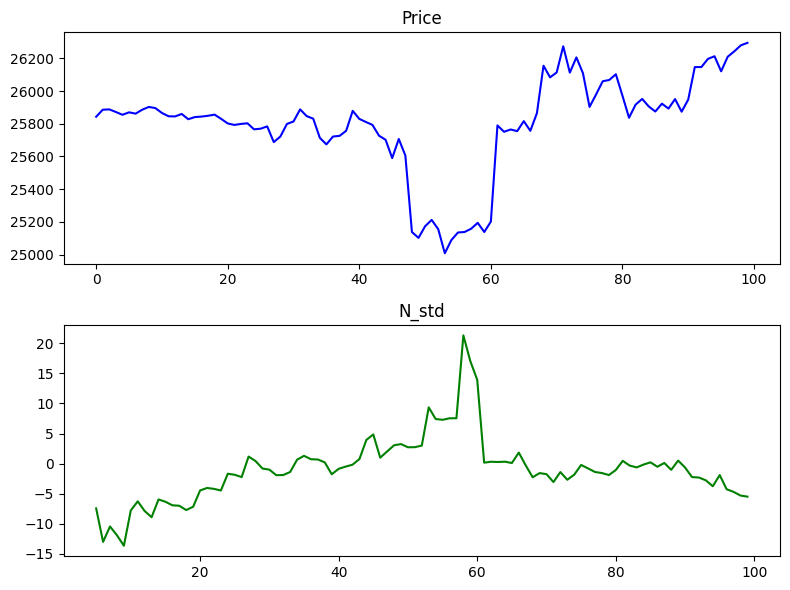

In [33]:
plot_n_std(df)

In [34]:
def plot_n_std_dev_signal(df):
        fig, ax = plt.subplots()
        colors = {
        0:'grey',
        1:'green',
        -1: 'red',
        0.5: 'yellow',
        -0.5: 'pink'
        }
        ax.scatter(
        np.reshape(df.index,-1),
        np.reshape(df['close'],-1),
        c=np.reshape(df['n_std_signal'].apply(lambda x: colors[x]),-1),
        s=10,
        linewidths = 1
        )
        plt.show()

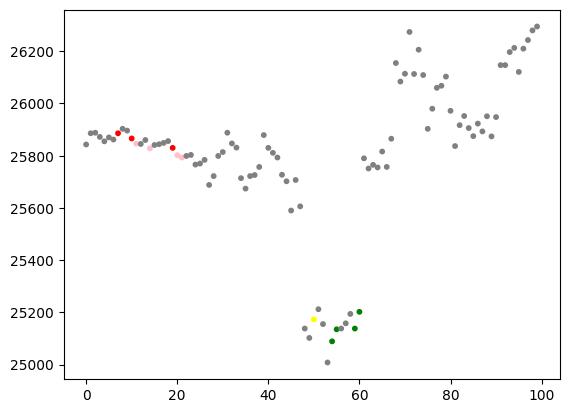

In [35]:
plot_n_std_dev_signal(df)

In [36]:
def calc_std_dev_levels(df):
        df['price_diff'] = df['close'].diff()
        df['std_dev'] = df['price_diff'].rolling(window=5).std()
        std_dev_ma_threshold_1 = df['std_dev'].quantile(0.2)
        std_dev_ma_threshold_2 = df['std_dev'].quantile(0.4)
        std_dev_ma_threshold_3 = df['std_dev'].quantile(0.6)
        std_dev_ma_threshold_4 = df['std_dev'].quantile(0.8)
        df['levels'] = 0  # Initialize 'signal' column with zeros
        df.loc[(df['std_dev'] > std_dev_ma_threshold_1), 'levels'] = 1
        df.loc[(df['std_dev'] > std_dev_ma_threshold_2), 'levels'] = 2
        df.loc[(df['std_dev'] > std_dev_ma_threshold_3), 'levels'] = 3
        df.loc[(df['std_dev'] > std_dev_ma_threshold_4), 'levels'] = 4
        return df

In [37]:
def plot_levels(df):
        import matplotlib.patches as mpatches

        fig, ax = plt.subplots()
        colors = {
            0:'grey',
            1:'green',
            2: 'blue',
            3: 'red',
            4: 'black'
        }
        scatter = ax.scatter(
            np.reshape(df.index, -1),
            np.reshape(df['close'], -1),
            c=np.reshape(df['levels'].apply(lambda x: colors[x]), -1),
            s=10,
            linewidths=1
        )

        # Create proxy artists for legend
        legend_labels = [f'Level {level}' for level in colors.keys()]
        legend_handles = [mpatches.Patch(color=colors[level], label=label) for level, label in enumerate(legend_labels)]

        # Create a legend
        ax.legend(handles=legend_handles, title='Levels')

        plt.title('std dev levels')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.grid(True)
        plt.show()

In [38]:
df = calc_std_dev_levels(df)

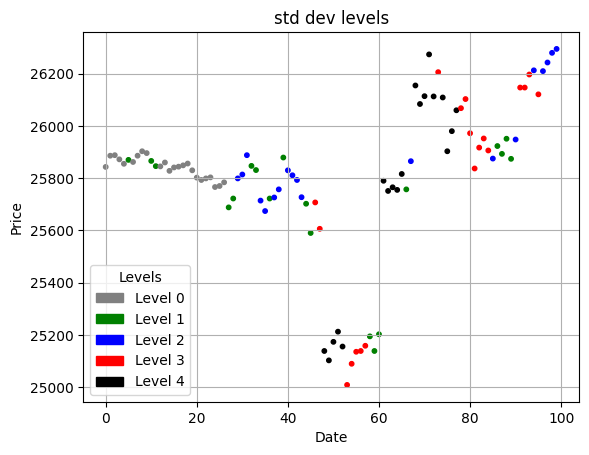

In [39]:
plot_levels(df)